In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import socket
import websocket
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
import requests
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
# ✅ Define Local Paths
dataset_path = "./DATASET"
train_dir = os.path.join(dataset_path, "TRAIN")
test_dir = os.path.join(dataset_path, "TEST")
save_model_path = "./saved_models/waste_classifier.h5"

In [3]:
# ✅ Image Preprocessing & Augmentation
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 22749 images belonging to 2 classes.
Found 2648 images belonging to 2 classes.


In [4]:
# ✅ Load MobileNetV2 Base Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
# ✅ Train the Model
model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    steps_per_epoch=len(train_data),
    validation_steps=len(test_data)
)

c:\Users\adith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 656s 918ms/step - accuracy: 0.8955 - loss: 0.2600 - val_accuracy: 0.8471 - val_loss: 0.3278
Epoch 2/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 870s 1s/step - accuracy: 0.9334 - loss: 0.1675 - val_accuracy: 0.8429 - val_loss: 0.3357
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 979s 1s/step - accuracy: 0.9422 - loss: 0.1530 - val_accuracy: 0.8225 - val_loss: 0.3786
Epoch 4/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 1006s 1s/step - accuracy: 0.9438 - loss: 0.1446 - val_accuracy: 0.8372 - val_loss: 0.3499
Epoch 5/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 1011s 1s/step - accuracy: 0.9479 - loss: 0.1348 - val_accuracy: 0.8421 - val_loss: 0.3319
Epoch 6/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 1010s 1s/step - accuracy: 0.9503 - loss: 0.1278 - val_accuracy: 0.8931 - val_loss: 0.2667
Epoch 7/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 1005s 1s/step - accuracy: 0.9509 - loss: 0.1234 - val_accuracy: 0.8652 - val_loss: 0.3141
Epoch 8/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 1005s 1s/step - accuracy: 0.9570 - loss: 0.1150 - 

In [6]:
# ✅ Save Model Locally
os.makedirs("./saved_models", exist_ok=True)
model.save(save_model_path)
print(f"Model saved at {save_model_path}")

Model saved at ./saved_models/waste_classifier.h5


In [3]:
try:
    ip = socket.gethostbyname("esp32.local")
    print("Resolved IP:", ip)
except Exception as e:
    print("Error resolving hostname:", e)
    exit()  # Exit if we can't resolve the address

Resolved IP: 192.168.51.108


In [4]:
def send_request(message):
    try:
        ws = websocket.create_connection(f"ws://{ip}:81")
        ws.send(message)
        response = ws.recv()
        print("Response:", response)
        ws.close()
    except Exception as e:
        print("WebSocket Error:", e)

In [5]:
# ✅ Real-Time Detection Using Webcam
def classify_waste_webcam():
    cap = cv2.VideoCapture(0)
    print(f"Using ESP at {"esp32.local"}")
    
    if not cap.isOpened():
        print("⚠️ Error: Could not access webcam!")
        return
    
    print("📷 Press SPACE to capture an image & classify, ESC to exit")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Failed to grab frame")
            break
        
        cv2.imshow("Webcam", frame)
        key = cv2.waitKey(1) & 0xFF
        
        if key == 32:  # SPACE key to capture
            img_path = "captured_waste.jpg"
            cv2.imwrite(img_path, frame)
            classify_waste(img_path)
        elif key == 27:  # ESC key to exit
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [6]:
# ✅ Function to Classify a Given Image & Send Result to ESP
def classify_waste(image_path):
    # Load the saved model
    model = load_model(save_model_path)
    print(f"Model loaded from {save_model_path}")
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0) / 255.0
    
    prediction = model.predict(img)[0][0]
    print("prediction: "+str(prediction))
    waste_type = "bio" if prediction < 0.4 else "non-bio"
    print(f"🗑️ Detected Waste Type: {waste_type}")
    
    send_request(waste_type)  # Send classification result to ESP
    
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title("Biodegradable 🟢" if waste_type == "bio" else "Non-Biodegradable 🔴")
    plt.axis("off")
    plt.show()

Using ESP at esp32.local
📷 Press SPACE to capture an image & classify, ESC to exit


Model loaded from ./saved_models/waste_classifier.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction: 0.023637451
🗑️ Detected Waste Type: bio
Response: Biodegradable Waste


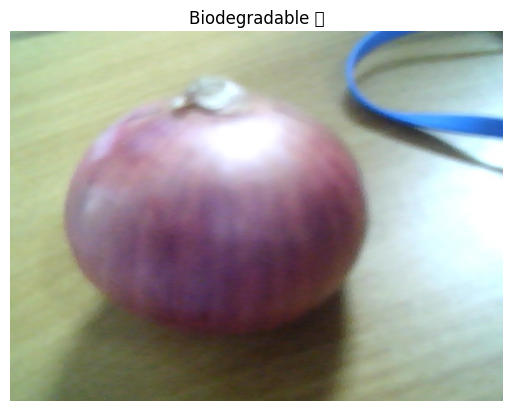

Model loaded from ./saved_models/waste_classifier.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction: 0.13389191
🗑️ Detected Waste Type: bio
Response: Biodegradable Waste


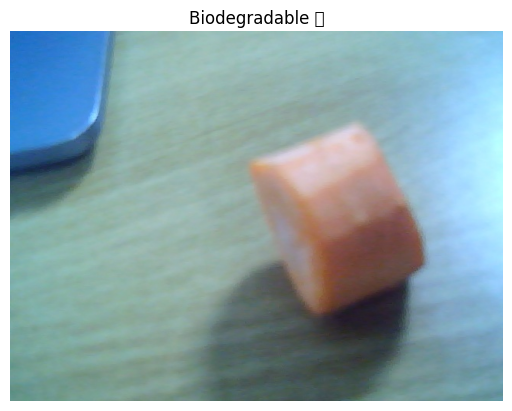

Model loaded from ./saved_models/waste_classifier.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction: 0.0016219752
🗑️ Detected Waste Type: bio
Response: Biodegradable Waste


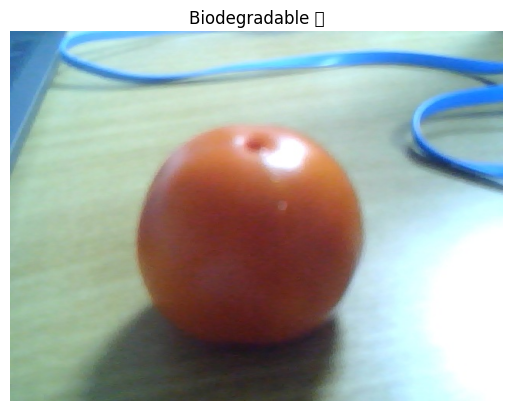

Model loaded from ./saved_models/waste_classifier.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction: 0.14049047
🗑️ Detected Waste Type: bio
Response: Biodegradable Waste


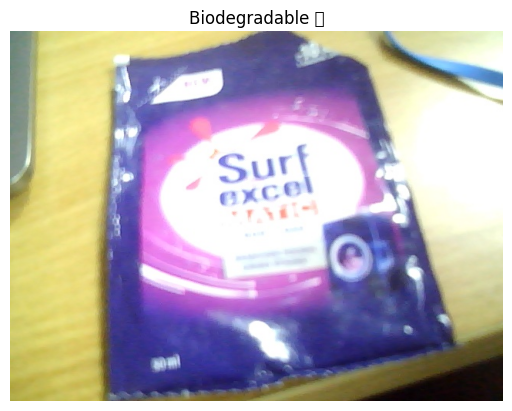

Model loaded from ./saved_models/waste_classifier.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction: 0.81023866
🗑️ Detected Waste Type: non-bio
Response: Non-Biodegradable Waste


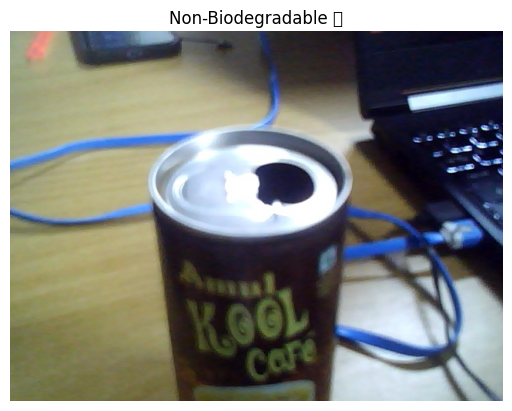

Model loaded from ./saved_models/waste_classifier.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction: 0.8973627
🗑️ Detected Waste Type: non-bio
Response: Non-Biodegradable Waste


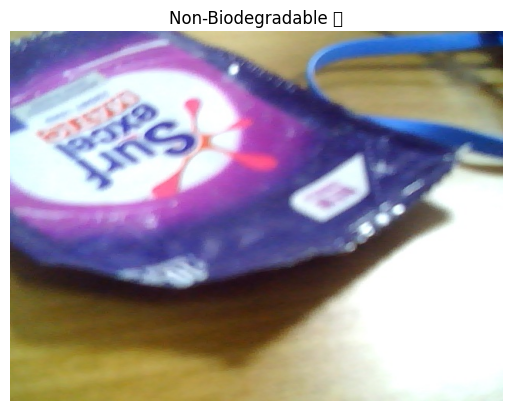

Model loaded from ./saved_models/waste_classifier.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction: 0.9988528
🗑️ Detected Waste Type: non-bio
Response: Non-Biodegradable Waste


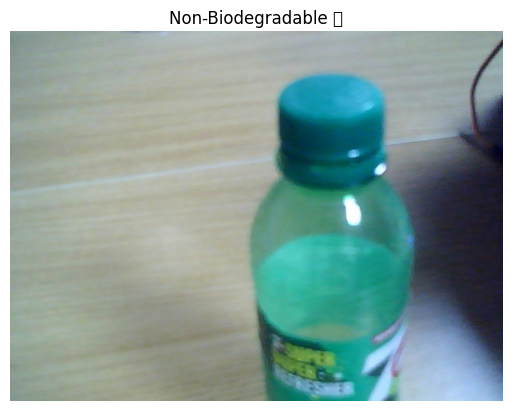

In [9]:

classify_waste_webcam()



